# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [52]:
!pip install jsonlines

In [0]:
import os
import json
import jsonlines
import numpy as np
from collections import defaultdict
import itertools
import operator
from tqdm import tqdm

## I. N-Gram Language Modeling

#### Utilities

In [0]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [55]:
datasets, vocab = load_wikitext()

Vocab size: 33175


### Additive Smoothing

In [0]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [0]:

# delta = 0.0005
# for n in [2, 3, 4]:
#     lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
#     lm.estimate(datasets['train'])

#     print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
#     print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

### I.1 Interpolation

In [0]:
class NGramInterpolation(object):
    pass

#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

## II. Neural Language Modeling with a Recurrent Neural Network

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, RandomSampler, SequentialSampler,DataLoader
import matplotlib.pyplot as plt

### Utilities

In [0]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>') # validation token is not seen in the training dataset
                                # <unk> is in the original training dataset. 
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [61]:
train_dict=Dictionary(datasets) # excluding validation dataset #109
#all_dict=Dictionary(datasets, include_valid = True)

# example
rand_int = np.random.randint(1, len(datasets['valid']))
print(' '.join(datasets['valid'][rand_int]))
encoded = train_dict.encode_token_seq(datasets['valid'][rand_int])
print(f'\n encoded - {encoded}')
decoded = train_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')

# checking
print('length of train_dict is ', len(train_dict)) # that's because <unk> is already in the dataset 
print('unique words in training dataset is ', len(vocab))

100%|██████████| 78274/78274 [02:19<00:00, 561.46it/s]

He was succeeded as AOC <unk> by Air Vice Marshal <unk> Murdoch .

 encoded - [858, 118, 5931, 14, 15272, 3, 28, 6074, 3048, 8170, 3, 30459, 39]

 decoded - ['He', 'was', 'succeeded', 'as', 'AOC', '<unk>', 'by', 'Air', 'Vice', 'Marshal', '<unk>', 'Murdoch', '.']
length of train_dict is  33178
unique words in training dataset is  33175


In [0]:
# given the dictionary from above, now write a function that tokenize the all datasets into id's
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

# Given a tokenzied dataset with ngram defined, slice the input sequences into n-grams 
# [0,1,2,3,4,5], 2 -> [0,1], [1,2], [2,3], [3,4], [4,5]
def slice_sequences_given_order(tokenized_dataset_with_spec, ngram_order=2):
    sliced_datasets = {}
    for split, dataset in tokenized_dataset_with_spec.items():
        _list_of_sliced_ngrams = []
        for seq in tqdm(dataset):
            ngrams = [seq[i:i+ngram_order] for i in range(len(seq)-ngram_order+1)]
            _list_of_sliced_ngrams.extend(ngrams)
        sliced_datasets[split] = _list_of_sliced_ngrams

    return sliced_datasets

# # Now we create a dataset
class NgramDataset(Dataset):
    def __init__(self, sliced_dataset_split):
        super().__init__()

        # for each sample: [:-1] is input, [-1] is target
        self.sequences = [torch.tensor(i, dtype=torch.long) for i in sliced_dataset_split]
    
    def __getitem__(self, i):
        sample = self.sequences[i]
        return sample

    def __len__(self):
        return len(self.sequences)

def batchify(list_minibatch):
    inp_list = [i[:-1] for i in list_minibatch]
    tar_list = [i[-1] for i in list_minibatch]

    inp_tensor = torch.stack(inp_list, dim=0) # list of tensors and create a new tensor a u-dimension specified by dim
    tar_tensor = torch.stack(tar_list, dim=0)
    # cat: take a list of tensors and use existing dimension to concatent. Cannot create a new u-dimension speicfied. 

    return inp_tensor, tar_tensor

In [63]:
#  returns dictionary of three items with 'train', 'valid' and 'test' with lists of token ids 
tokenized_ngram = tokenize_dataset(datasets, train_dict, ngram_order=2)

# returns dictionary of three and lists of sliced n-grams
sliced_ngram = slice_sequences_given_order(tokenized_ngram, ngram_order=2)

# check that the sentence is encoded with (n-1)<bos> and can be decoded back to tokens 
decoded_with_spec = train_dict.decode_idx_seq(tokenized_ngram['train'][3010])
print(f'\n decoded with spec - {decoded_with_spec}')

ngram_datasets = {}
ngram_loaders = {}
for split, dataset_sliced in sliced_ngram.items():
    if split == 'train':
        shuffle_ = True
    else:
        shuffle_ = False
    dataset_ = NgramDataset(dataset_sliced)
    ngram_datasets[split] = dataset_
    ngram_loaders[split] = DataLoader(dataset_, batch_size=2048, shuffle=shuffle_, collate_fn=batchify)

100%|██████████| 9708/9708 [00:00<00:00, 138521.66it/s]



 decoded with spec - ['<bos>', 'The', 'Nataraja', 'and', 'Ardhanarishvara', 'sculptures', 'are', 'also', 'attributed', 'to', 'the', 'Rashtrakutas', '.', '<eos>']


In [64]:
print('The length of original training dataset is: ', len(datasets['train']))
print('The length of tokenzied training dataset is: ', len(tokenized_ngram['train']))
print('Slided_ngram for training dataset now has length of ', len(sliced_ngram['train']))

The length of original training dataset is:  78274
The length of tokenzied training dataset is:  78274
Slided_ngram for training dataset now has length of  2003028


In [65]:
print(tokenized_ngram['valid'][10])
print(train_dict.decode_idx_seq(tokenized_ngram['valid'][10]))

[0, 504, 1506, 7106, 741, 459, 20, 140, 98, 432, 19366, 10, 150, 15605, 13, 260, 3748, 955, 1826, 1384, 1145, 98, 1722, 4303, 39, 1]
['<bos>', 'This', 'may', 'occur', 'several', 'times', 'a', 'year', 'for', 'young', 'lobsters', ',', 'but', 'decreases', 'to', 'once', 'every', '1', '–', '2', 'years', 'for', 'larger', 'animals', '.', '<eos>']


In [0]:
class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])
    
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors]) # t.size(-1) changes the type from torch.Size to int.
    padded_list = []
    
    for t in list_of_tensors:  # dim = 0: cat on row, dim = 1: add on column 
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = persona_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor



In [67]:
tensor_dataset = {}

# split: train, valid, test
for split, listoflists in tokenized_ngram.items():
    tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
tensor_dataset['train'][24]

(tensor([[  0, 282,  13, 283, 181, 194, 195, 284,  13,  20, 285, 286,  39]]),
 tensor([[282,  13, 283, 181, 194, 195, 284,  13,  20, 285, 286,  39,   1]]))

In [0]:
loaders = {}
batch_size = 32
for split, dataset in tensor_dataset.items():
    loaders[split] = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

### Baseline Model: RNN

In [0]:
from torch.nn import RNNBase, RNN
from torch.nn import Embedding
from torch.nn import Linear, functional
import torch.optim as optim

In [70]:
# example embedding layer
lookup = Embedding(num_embeddings=len(train_dict), embedding_dim=64, padding_idx=train_dict.get_id('<pad>'))
lookup.weight.size()
# train_dict = vocab size + 4

torch.Size([33178, 64])

In [71]:
# Example input
input_ = train_dict.encode_token_seq('hello world'.split(' '))
print(f'discrete input: {[input_]}')

input_continious = lookup(torch.tensor([input_], dtype=torch.long))
print(f'continious input size: {input_continious.size()}')

discrete input: [[3, 693]]
continious input size: torch.Size([1, 2, 64])


In [0]:
lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
# before nn.RNN is hidden
# Now: you do lookup table, and returns the tensors of sequence. No need of concat, becuase RNN naturally takes care of this
# RNN natrually takes multi sentence inputs and outputs hidden_size 
rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
projection = nn.Linear(options['hidden_size'], options['num_embeddings'])

In [77]:
lookup

Embedding(33178, 64, padding_idx=2)

In [78]:
rnn

RNN(64, 128, num_layers=2, batch_first=True, dropout=0.1)

In [79]:
projection

Linear(in_features=128, out_features=33178, bias=True)

In [0]:

import torch.nn as nn

class RNNLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        # before nn.RNN is hidden
        # Now: you do lookup table, and returns the tensors of sequence. No need of concat, becuase RNN naturally takes care of this
        # RNN natrually takes multi sentence inputs and outputs hidden_size 
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs = self.rnn(embeddings)
        # project of outputs 
        # rnn_outputs: tupple with second element being last hidden state. 
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [0]:
# This cell need to be moved forward in oder to prevent error from occuring.
load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('personachat_rnn_lm.pt')
    
    options = model_dict['options']
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 64
    hidden_size = 128 # output of dimension 
    num_layers = 2
    rnn_dropout = 0.1
    input_size = lookup.weight.size(1)
    vocab_size = lookup.weight.size(0)
    
    options = {
        'num_embeddings': len(train_dict),
        'embedding_dim': embedding_size,
        'padding_idx': train_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }

    
    model = RNNLanguageModel(options).to(current_device)

# same as previous nn based 
criterion = nn.CrossEntropyLoss(ignore_index=train_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)



In [82]:
# check model
model

RNNLanguageModel(
  (lookup): Embedding(33178, 64, padding_idx=2)
  (rnn): RNN(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33178, bias=True)
)

In [0]:
# check the following two chunks out 

In [84]:

plot_cache = []

for epoch_number in range(100):
    avg_loss=0
    if not load_pretrained:
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break

Step 0 avg train loss = 10.4347
Step 100 avg train loss = 7.7255
Step 200 avg train loss = 6.9448
Step 300 avg train loss = 6.7479
Step 400 avg train loss = 6.6020
Step 500 avg train loss = 6.5238
Step 600 avg train loss = 6.4444
Step 700 avg train loss = 6.3687
Step 800 avg train loss = 6.3088
Step 900 avg train loss = 6.2642
Step 1000 avg train loss = 6.2030
Step 1100 avg train loss = 6.1762
Step 1200 avg train loss = 6.1313
Step 1300 avg train loss = 6.1102
Step 1400 avg train loss = 6.0654
Step 1500 avg train loss = 6.0286
Step 1600 avg train loss = 6.0137
Step 1700 avg train loss = 5.9976
Step 1800 avg train loss = 5.9683
Step 1900 avg train loss = 5.9564
Step 2000 avg train loss = 5.9412
Step 2100 avg train loss = 5.9246


KeyboardInterrupt: ignored

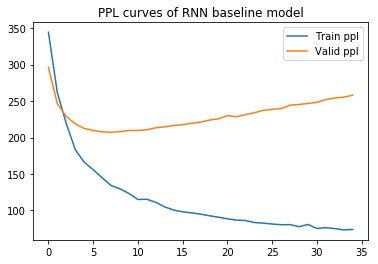

In [52]:
epochs = np.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/np.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/np.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves of RNN baseline model')
plt.show()

### II.1 LSTM and Hyper-Parameters

In [0]:
from torch.nn import LSTM
# input_size, hidden_size, num_layers. 
# Optional: bias = False, dropout = 0 (probability of dropout)
# bidirectional = False. 
rnn = nn.LSTM(10, 20, 2)

# input: tensor containing feature of the input sequence 
# shape: seq_len, batch, input_size
input = torch.randn(5,3,10)

#h0: tensor contain hidden state for t = seq_len
# shape: num_layers * num*directions, batch, hidden_size
h0 = torch.randn(2,3,20)

#c0: tensor contain cell state for t = seq_length
# shape: num_layers * num_directions, batch, hidden_size 
c0 = torch.randn(2,3,20)

# output: shape (seq_len, batch, num_direction * hidden size)
output, (hn,cn) = rnn(input, (h0,c0))

In [86]:
# example embedding layer
lookup = Embedding(num_embeddings=len(train_dict), embedding_dim=64, padding_idx=train_dict.get_id('<pad>'))
lookup.weight.size()
# train_dict = vocab size + 3

torch.Size([33178, 64])

In [0]:
# From the baseline, we will stop the epoch around 20 
class LSTMModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], 
                            dropout=options['lstm_dropout'], batch_first=True, bias = options['bias'],
                           bidirectional = options['bid'])
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        lstm_outputs = self.lstm(embeddings)
        # project of outputs 
        # rnn_outputs: tupple with second element being last hidden state. 
        logits = self.projection(lstm_outputs[0])
        
        return logits

In [0]:

load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('personachat_rnn_lm.pt')
    
    options = model_dict['options']
    model = LSTMModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 64
    hidden_size = 128 # output of dimension 
    num_layers = 2
    lstm_dropout = 0.1
#     input_size = lookup.weight.size(1)
    vocab_size = len(train_dict)
    
    options = {
        'num_embeddings': len(train_dict),
        'embedding_dim': embedding_size,
        'padding_idx': train_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        'bias': True,
        'bid': False 
    }

    
    model = LSTMModel(options).to(current_device)

# same as previous nn based 
criterion = nn.CrossEntropyLoss(ignore_index=train_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)

In [89]:
model

LSTMModel(
  (lookup): Embedding(33178, 64, padding_idx=2)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33178, bias=True)
)

In [91]:
#model = LSTMModel(options).to(current_device)
plot_cache = []
min_val_loss = 20 
for epoch_number in range(20):
    avg_loss=0
    if not load_pretrained:
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        best = avg_val_loss < min_val_loss
        if best:
            min_val_loss = avg_val_loss
            best_model = model
                        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break
        
print('Saving best model...')
torch.save({
'options': options,
'loss_cache': plot_cache,
'model_dict': best_model.state_dict()
        }, './baseline_LSTM.pt')



Step 0 avg train loss = 7.0863
Step 100 avg train loss = 7.0200
Step 200 avg train loss = 6.9266
Step 300 avg train loss = 6.8133
Step 400 avg train loss = 6.7200
Step 500 avg train loss = 6.6318
Step 600 avg train loss = 6.5733
Step 700 avg train loss = 6.5168
Step 800 avg train loss = 6.4810
Step 900 avg train loss = 6.4369
Step 1000 avg train loss = 6.3943
Step 1100 avg train loss = 6.3615
Step 1200 avg train loss = 6.3266
Step 1300 avg train loss = 6.2870
Step 1400 avg train loss = 6.2620
Step 1500 avg train loss = 6.2168
Step 1600 avg train loss = 6.2051
Step 1700 avg train loss = 6.1710
Step 1800 avg train loss = 6.1293
Step 1900 avg train loss = 6.1156
Step 2000 avg train loss = 6.0862
Step 2100 avg train loss = 6.0944
Step 2200 avg train loss = 6.0612
Step 2300 avg train loss = 6.0266
Step 2400 avg train loss = 6.0032
Validation loss after 0 epoch = 5.8233
Step 0 avg train loss = 5.8466
Step 100 avg train loss = 5.9111
Step 200 avg train loss = 5.8860
Step 300 avg train loss = 

KeyboardInterrupt: ignored

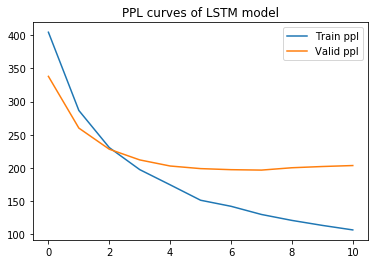

In [92]:
epochs = np.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/np.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/np.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves of LSTM model')
plt.show()

In [93]:
perp = [2**(i[1]/np.log(2)) for i in plot_cache] 
print('The minimum validation loss occurred at {} and it is {}'.format(perp.index(min(perp)),min(perp)))

The minimum validation loss occurred at 7 and it is 196.54008318910067


In [0]:
# train the model with hyperparamters chosen: embed_dim: 300, hidden_zise = 300


load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('personachat_rnn_lm.pt')
    
    options = model_dict['options']
    model = LSTMModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 300
    hidden_size = 300 # output of dimension 
    num_layers = 2
    lstm_dropout = 0.1
#     input_size = lookup.weight.size(1)
    vocab_size = len(train_dict)
    
    options = {
        'num_embeddings': len(train_dict),
        'embedding_dim': embedding_size,
        'padding_idx': train_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        'bias': True,
        'bid': False 
    }

    
    model = LSTMModel(options).to(current_device)

# same as previous nn based 
criterion = nn.CrossEntropyLoss(ignore_index=train_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)

In [96]:
model

LSTMModel(
  (lookup): Embedding(33178, 300, padding_idx=2)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=300, out_features=33178, bias=True)
)

In [47]:
#model = LSTMModel(options).to(current_device)
plot_cache = []
min_val_loss = 20 
epoch_num = 20
for epoch_number in range(epoch_num):
    avg_loss=0
    if not load_pretrained:
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        best = avg_val_loss < min_val_loss
        if best:
            min_val_loss = avg_val_loss
            best_model = model
            print("update the best to:")
            print(best_model)
            print("current validation loss is:")
            print(min_val_loss)
                        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break
        
print('Saving best model...')
torch.save({
'options': options,
'loss_cache': plot_cache,
'model_dict': best_model.state_dict()
        }, './best_300_300_LSTM.pt')



Step 0 avg train loss = 7.0963
Step 100 avg train loss = 7.1643
Step 200 avg train loss = 6.9912
Step 300 avg train loss = 6.8097
Step 400 avg train loss = 6.6316
Step 500 avg train loss = 6.5043
Step 600 avg train loss = 6.4055
Step 700 avg train loss = 6.3217
Step 800 avg train loss = 6.2781
Step 900 avg train loss = 6.1911
Step 1000 avg train loss = 6.1272
Step 1100 avg train loss = 6.0845
Step 1200 avg train loss = 6.0255
Step 1300 avg train loss = 6.0025
Step 1400 avg train loss = 5.9498
Step 1500 avg train loss = 5.9080
Step 1600 avg train loss = 5.8947
Step 1700 avg train loss = 5.8399
Step 1800 avg train loss = 5.7976
Step 1900 avg train loss = 5.8105
Step 2000 avg train loss = 5.7670
Step 2100 avg train loss = 5.7527
Step 2200 avg train loss = 5.7363
Step 2300 avg train loss = 5.6854
Step 2400 avg train loss = 5.6774
Validation loss after 0 epoch = 5.5204
update the best to:
LSTMModel(
  (lookup): Embedding(33178, 300, padding_idx=2)
  (lstm): LSTM(300, 300, num_layers=2, batc

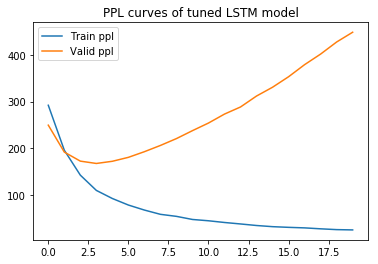

In [49]:
epochs = np.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/np.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/np.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves of tuned LSTM model')
plt.show()

In [50]:
perp = [2**(i[1]/np.log(2)) for i in plot_cache] 
print('The minimum validation loss occurred at {} and it is {}'.format(perp.index(min(perp)),min(perp)))

The minimum validation loss occurred at 3 and it is 168.0075867791675


#### Results (LSTM vs. Baseline)

In [61]:
# first hyperparameter tuning
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'
# single grid search for the hyperparameter tuning
param_grid_emb = {"embedding_size": [100,200,300,400,500]}      

# list of parameters=========== 
epoch_num = 20
hidden_size = 128 # the second hyperparameter to be tuned. 
learning_rate=0.001
# Loop over embedding size:
for embedding_size in param_grid_emb["embedding_size"]:
  
  embedding_size = embedding_size
  hidden_size = hidden_size # output of dimension 
  num_layers = 2
  lstm_dropout = 0.1
# input_size = lookup.weight.size(1)
  vocab_size = len(train_dict)
  
  options = {
        'num_embeddings': len(train_dict),
        'embedding_dim': embedding_size,
        'padding_idx': train_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        'bias': True,
        'bid': False 
    }
  
  model = LSTMModel(options).to(current_device)
  
  criterion = nn.CrossEntropyLoss(ignore_index=train_dict.get_id('<pad>'))
  model_parameters = [p for p in model.parameters() if p.requires_grad]
  optimizer = optim.Adam(model_parameters, lr=learning_rate)
  
  print(model)
  
  plot_cache = []
  min_val_loss = 20   # why is it 20??

  for epoch_number in range(epoch_num):
    
    # do train 
    avg_loss=0
    if not load_pretrained:
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        best = avg_val_loss < min_val_loss
        if best:
            min_val_loss = avg_val_loss
            best_model = model
                        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break

# save the best model in this single grid search:         
print('Saving best model with best embedding dimension...')
torch.save({
'options': options,
'loss_cache': plot_cache,
'model_dict': best_model.state_dict()
        }, './emb_tune_best_LSTM.pt')



  

LSTMModel(
  (lookup): Embedding(33178, 100, padding_idx=2)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33178, bias=True)
)
Step 0 avg train loss = 10.4213
Step 100 avg train loss = 7.8746
Step 200 avg train loss = 7.1487
Step 300 avg train loss = 6.9989
Step 400 avg train loss = 6.8819
Step 500 avg train loss = 6.7695
Step 600 avg train loss = 6.6904
Step 700 avg train loss = 6.6061
Step 800 avg train loss = 6.5169
Step 900 avg train loss = 6.4813
Step 1000 avg train loss = 6.4483
Step 1100 avg train loss = 6.3791
Step 1200 avg train loss = 6.3451
Step 1300 avg train loss = 6.3354
Step 1400 avg train loss = 6.2372
Step 1500 avg train loss = 6.2236
Step 1600 avg train loss = 6.1985
Step 1700 avg train loss = 6.1570
Step 1800 avg train loss = 6.1361
Step 1900 avg train loss = 6.1115
Step 2000 avg train loss = 6.0735
Step 2100 avg train loss = 6.0716
Step 2200 avg train loss = 6.0352
Step 2300 avg train loss =

In [42]:
# second hyperparameter tuning
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

# single grid search for the hyperparameter tuning
param_grid_hid_size = {"hidden_size": [300,400,500]}       

# list of parameters=========== 
epoch_num = 20
embedding_size = 300 # find the best embedding size 5.2010 after 5 epoch
learning_rate=0.001
overall_min_val_loss = 20
# Loop over embedding size:
for hidden_size in param_grid_hid_size["hidden_size"]:
  
  embedding_size = embedding_size
  hidden_size = hidden_size # output of dimension 
  num_layers = 2
  lstm_dropout = 0.1
# input_size = lookup.weight.size(1)
  vocab_size = len(train_dict)
  
  options = {
        'num_embeddings': len(train_dict),
        'embedding_dim': embedding_size,
        'padding_idx': train_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        'bias': True,
        'bid': False 
    }
  
  model = LSTMModel(options).to(current_device)
  
  criterion = nn.CrossEntropyLoss(ignore_index=train_dict.get_id('<pad>'))
  model_parameters = [p for p in model.parameters() if p.requires_grad]
  optimizer = optim.Adam(model_parameters, lr=learning_rate)
  
  print(model)
  
  plot_cache = []
  min_val_loss = 20   

  for epoch_number in range(epoch_num):
    
    # do train 
    avg_loss=0
    if not load_pretrained:
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        best = avg_val_loss < min_val_loss
        if best:
            min_val_loss = avg_val_loss
            best_model = model
            print("update best model with this parameter to :")
            print(best_model)
    
    plot_cache.append((avg_loss, avg_val_loss))
    
    
    if load_pretrained:
        break
  
  if (min_val_loss < overall_min_val_loss):
    best_model_overall = best_model
    overall_min_val_loss = min_val_loss
    print("update overall best model to :")
    print(best_model_overall)
    
# save the best model in this single grid search:         
print('Saving best model with best hidden size...')
torch.save({
'options': options,
'loss_cache': plot_cache,
'model_dict': best_model_overall.state_dict()
        }, './hid_tune_best_LSTM.pt')

LSTMModel(
  (lookup): Embedding(33178, 300, padding_idx=2)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=300, out_features=33178, bias=True)
)
Step 0 avg train loss = 10.4099
Step 100 avg train loss = 7.6503
Step 200 avg train loss = 7.1205
Step 300 avg train loss = 6.9481
Step 400 avg train loss = 6.7299
Step 500 avg train loss = 6.5959
Step 600 avg train loss = 6.4814
Step 700 avg train loss = 6.3755
Step 800 avg train loss = 6.3012
Step 900 avg train loss = 6.2247
Step 1000 avg train loss = 6.1656
Step 1100 avg train loss = 6.1052
Step 1200 avg train loss = 6.0663
Step 1300 avg train loss = 6.0285
Step 1400 avg train loss = 5.9922
Step 1500 avg train loss = 5.9431
Step 1600 avg train loss = 5.9030
Step 1700 avg train loss = 5.8825
Step 1800 avg train loss = 5.8530
Step 1900 avg train loss = 5.8168
Step 2000 avg train loss = 5.7784
Step 2100 avg train loss = 5.7565
Step 2200 avg train loss = 5.7259
Step 2300 avg train loss =

FileNotFoundError: ignored

In [98]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#### Performance Variation Based on Hyperparameter Values

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [0]:
# TODO: Get the best model parameter from 1.2.1 
options = {
        'num_embeddings': len(train_dict),
        'embedding_dim': embedding_size,
        'padding_idx': train_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        'bias': True,
        'bid': False 
    }
model = LSTMModel(options)
model.load_state_dict(torch.load('baseline_LSTM.pt')['model_dict'])
model.eval()

LSTMModel(
  (lookup): Embedding(33178, 64, padding_idx=2)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33178, bias=True)
)

In [0]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy()) 
    # transfer tensor back to cpu
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/home/sl7085/.conda/envs/myenv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### II.2.1 Word Similarity

In [0]:
def cos_similarity(weight_matrix, words):
#make sure at least appear in the text once 
    whole_word = list()
    for word in words:
        if word not in vocab:
            raise NotImplementedError("selected token must appeared in the corpus once, please replace {}".format(word))
            
    # define my cosine similarity. each input is 1 x 64. Therefore evaluate along x'axis returns a scalar 
    cos = nn.CosineSimilarity(dim = 0, eps = 1e-6)

    dis_list = defaultdict(lambda: defaultdict(float))

    for w in words:
        wid = train_dict.get_id(w)
        temp_list = list()
        for i in range(len(weight_matrix)):
            if i == wid:
                continue
            else: 
                dis = cos(weight_matrix[wid], weight_matrix[i])
                temp_list.append(tuple((train_dict.get_token(i), dis.item())))
        temp_list = sorted(temp_list, key = lambda x: x[-1])
        dis_list[w]['worst'] = temp_list[:10]
        dis_list[w]['best'] = temp_list[-10:]
        worst_words = [x[0] for x in temp_list[:10]]
        best_words = [x[0] for x in temp_list[-10:]]
        whole_word += worst_words + best_words
    return dis_list, whole_word + words

#### II.2.2 Embedding Layer

In [0]:
weight_matrix_lkup = model.lookup.weight
words = ['productive', 'teenage','south','antelope','smart']
# some verbs, and nouns
lkup_list, whole_words_lkup = cos_similarity(weight_matrix_lkup, words)

In [0]:
lkup_list['smart']['best']

[('fuelled', 0.4145849049091339),
 ('Bethlehem', 0.4171598553657532),
 ('window', 0.42124074697494507),
 ('drills', 0.4226926565170288),
 ('gamma', 0.4253535270690918),
 ('Trujillo', 0.4524407684803009),
 ('Helikopter', 0.45847856998443604),
 ('sufficient', 0.4664282500743866),
 ('gorgeously', 0.472387433052063),
 ('pyrite', 0.4758983552455902)]

In [0]:
lkup_list['smart']['worst']

[('Hartington', -0.4613579511642456),
 ('astonished', -0.45143312215805054),
 ('none', -0.446800172328949),
 ('Kannada', -0.4442085027694702),
 ('508', -0.43341436982154846),
 ('Moltke', -0.42936182022094727),
 ('ambush', -0.42904070019721985),
 ('ligand', -0.4222765266895294),
 ('skyline', -0.4182506203651428),
 ('surge', -0.4146639108657837)]

/home/sl7085/.conda/envs/myenv/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.conda/envs/myenv/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/sl7085/.conda/envs/myenv/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.conda/envs/myenv/lib/python3.6/site-pac

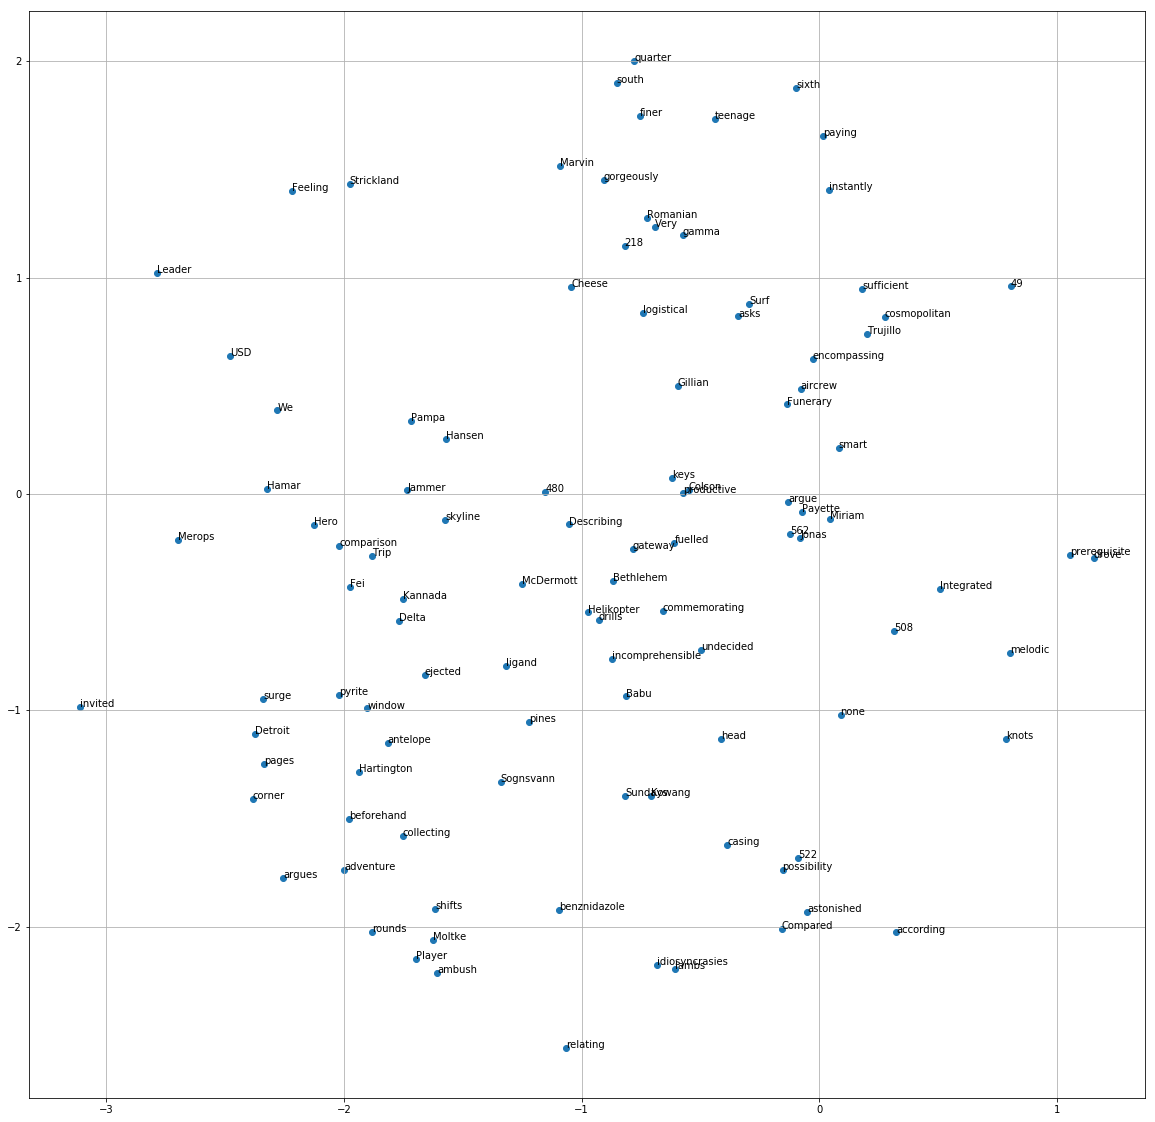

In [0]:
whole_word_ids_lkup = train_dict.encode_token_seq(whole_words_lkup)   # e.g. use dictionary.get_id on a list of words

umap_plot(weight_matrix_lkup, whole_word_ids_lkup, whole_words_lkup)

#### II.2.3 Projection Layer

In [0]:
weight_matrix_proj = model.projection.weight
words = ['productive', 'teenage','south','antelope','smart']
# some verbs, and nouns
proj_list, whole_words_proj = cos_similarity(weight_matrix_proj, words)

In [0]:
proj_list['productive']['best']

[('rudders', 0.7861390113830566),
 ('dihedral', 0.7878164052963257),
 ('cruciform', 0.7883051633834839),
 ('webisode', 0.7900282144546509),
 ('dose', 0.7945231795310974),
 ('recourse', 0.7983407974243164),
 ('cun', 0.8006885647773743),
 ('moult', 0.8121520280838013),
 ('epidemic', 0.8251773715019226),
 ('smile', 0.8261529207229614)]

In [0]:
proj_list['productive']['worst']

[('and', -0.34913504123687744),
 ('was', -0.26380446553230286),
 ('is', -0.23950541019439697),
 ('"', -0.22181227803230286),
 ('the', -0.18868812918663025),
 ('<unk>', -0.17997287213802338),
 ('The', -0.16852892935276031),
 (',', -0.15113075077533722),
 ('it', -0.12440523505210876),
 ('<eos>', -0.11839520931243896)]

/home/sl7085/.conda/envs/myenv/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.conda/envs/myenv/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


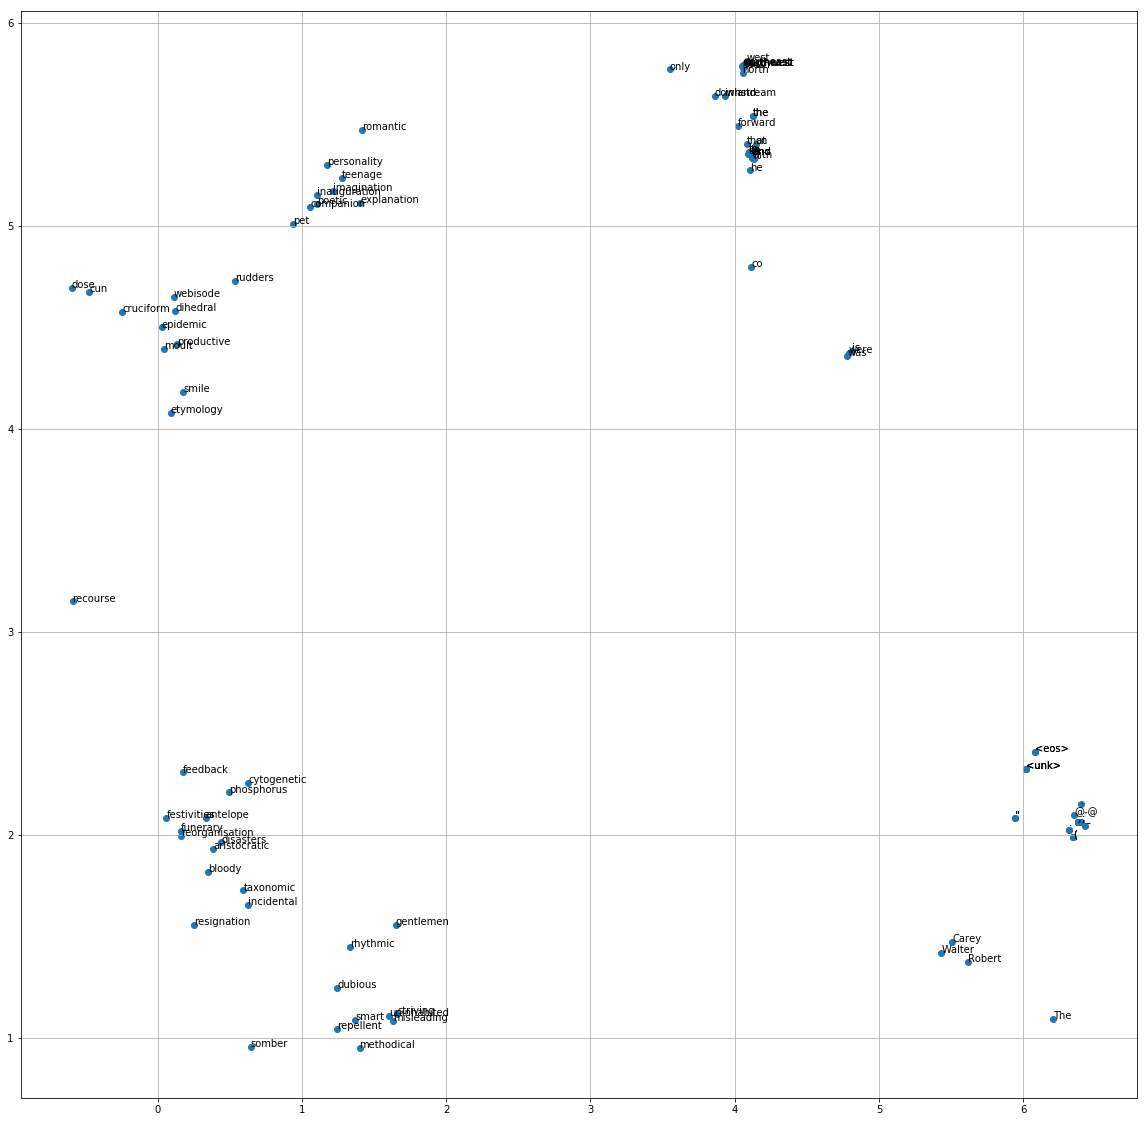

In [0]:
whole_word_ids_proj = train_dict.encode_token_seq(whole_words_proj)   # e.g. use dictionary.get_id on a list of words
umap_plot(weight_matrix_proj, whole_word_ids, whole_words_proj)

### II.3 Scoring

#### II.3.2 Highest and Lowest scoring sequences

#### II.3.3 Modified sequences

### II.4 Sampling

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

#### II.4.4 Example Samples